In [1]:
!pip install tweet-preprocessor
!pip install icecream
!pip install string-grouper
import numpy as np
import pandas as pd
import preprocessor as p
from sklearn.model_selection import GridSearchCV
from icecream import ic
import spacy
from string_grouper import match_strings, match_most_similar, group_similar_strings, StringGrouper


ERROR: gensim 3.8.3 has requirement Cython==0.29.14, but you'll have cython 0.29.21 which is incompatible.


  Using cached Cython-0.29.21-cp38-cp38-win_amd64.whl (1.7 MB)
  Attempting uninstall: cython
    Found existing installation: Cython 0.29.14
    Uninstalling Cython-0.29.14:
      Successfully uninstalled Cython-0.29.14


In [2]:
import seaborn as sns

In [4]:
tweets = pd.read_csv("labeled_tweets.csv")

In [5]:
nlp = spacy.load("en_core_web_sm")

In [6]:
tweets

,text,label1,label2
0,While athletes and other attendees at this sum...,sports,health
1,The family of a military veteran who died in 2...,politics,NaN
2,A state lawmaker in Missouri was charged this ...,health,politics
3,U.S. Defense Secretary Lloyd Austin convened t...,politics,NaN
4,Who knew that it could be so much fun to watch...,politics,entertainment
...,...,...,...
540,Elon Musk’s SpaceX announces a spaceflight int...,business,NaN
541,"As House GOP faces decision on its future, McC...",politics,NaN
542,The GameStop stock situation isn’t about popul...,business,NaN
543,"Opinion: Confederate names are coming down, bu...",politics,NaN


In [7]:
tweets.text = tweets.text.str.lower()
tweets.text = tweets.text.apply(p.clean)
tweets.fillna("NA", inplace=True)

In [8]:
tweets # Clean version of tweets

,text,label1,label2
0,while athletes and other attendees at this sum...,sports,health
1,the family of a military veteran who died in a...,politics,NA
2,a state lawmaker in missouri was charged this ...,health,politics
3,u.s. defense secretary lloyd austin convened t...,politics,NA
4,who knew that it could be so much fun to watch...,politics,entertainment
...,...,...,...
540,elon musks spacex announces a spaceflight inte...,business,NA
541,"as house gop faces decision on its future, mcc...",politics,NA
542,the gamestop stock situation isnt about populi...,business,NA
543,"opinion: confederate names are coming down, bu...",politics,NA


In [12]:
def named_entity_tokens(string):
    """
    Returns a list of named entities from a string
    Can be applied to tweets.text
    """
    entities = []
    doc = nlp(string)
    for ent in doc.ents:
        if ent.label_ == "MONEY":
            continue
#         d2 = nlp(str(ent))
#         for e in d2.ents:
        entities.append(str(ent))           
        return entities

In [13]:
def build_ner_corpus(tweets):
    
    """
    Function that builds NER Corpus from the tweets dataframe
    Returns a single long list of named entities
    """
    ner_corpus = []
    tweets['entities'] = tweets.text.apply(named_entity_tokens)
    for entity_list in tweets.entities:
        print(entity_list)
        if entity_list != None:
            ner_corpus.extend(entity_list)
    return ner_corpus


In [15]:
net_entities_list = build_ner_corpus(tweets)    # Full long list of entities

['tokyo olympic games']
['atlanta']
['missouri']
['u.s.']
['kathryn grody']
['biden']
['wednesday']
['house']
['first']
['wednesday']
['mckinsey']
['new york']
['keith gill']
['columbus']
['the chicago teachers union']
None
['san francisco']
['yoshiro mori']
['kevin mccarthy']
['jeff bezos']
['the texas department of public safety']
['queens']
['just %']
['new jersey']
None
['new york city']
['oxford-astrazeneca']
['the university of oxford']
['chimpanzees']
['as recently as december']
['the supreme court']
['missouri']
['maria bakalova']
['eugenio martinez']
['alexandria']
['britain']
['the five minutes']
None
['romo mivekannins great-great-grandfather']
['sunday']
['brian sicknick']
['minari']
['louisville']
['riz ahmed']
['biden']
['recent years']
['the justice department']
['canada']
None
['mahfouf']
['mahfouf']
['lna mahfouf']
['frdric beigbeder']
['-year-old']
['house']
['the day']
['senate']
['the golden globe']
['biden']
['the golden globe']
['michaela coel']
['arizonas democra

In [16]:
# Cleaning named entity list by removing apostrophes and dots

net_entities_list = pd.Series(net_entities_list)
net_entities_list = net_entities_list.str.replace("'s", "")
net_entities_list = net_entities_list.str.replace(".", "")

In [17]:
tweets['tokens'] = net_entities_list # Appending to tweets DF as a column

In [19]:
tweets

,text,label1,label2,entities,tokens
0,while athletes and other attendees at this sum...,sports,health,[tokyo olympic games],tokyo olympic games
1,the family of a military veteran who died in a...,politics,NA,[atlanta],atlanta
2,a state lawmaker in missouri was charged this ...,health,politics,[missouri],missouri
3,u.s. defense secretary lloyd austin convened t...,politics,NA,[u.s.],us
4,who knew that it could be so much fun to watch...,politics,entertainment,[kathryn grody],kathryn grody
...,...,...,...,...,...
540,elon musks spacex announces a spaceflight inte...,business,NA,[elon musks spacex],NaN
541,"as house gop faces decision on its future, mcc...",politics,NA,[house gop],NaN
542,the gamestop stock situation isnt about populi...,business,NA,None,NaN
543,"opinion: confederate names are coming down, bu...",politics,NA,[san francisco],NaN


In [20]:
similarized_entities_list = group_similar_strings(net_entities_list) # Grouping similar entities together

In [21]:
similarized_entities_list.value_counts()

us                     35
house                  12
biden                   8
senate                  8
russia                  8
                       ..
lindsey graham          1
hong kong               1
chimpanzees             1
country star morgan     1
sunday                  1
Length: 269, dtype: int64

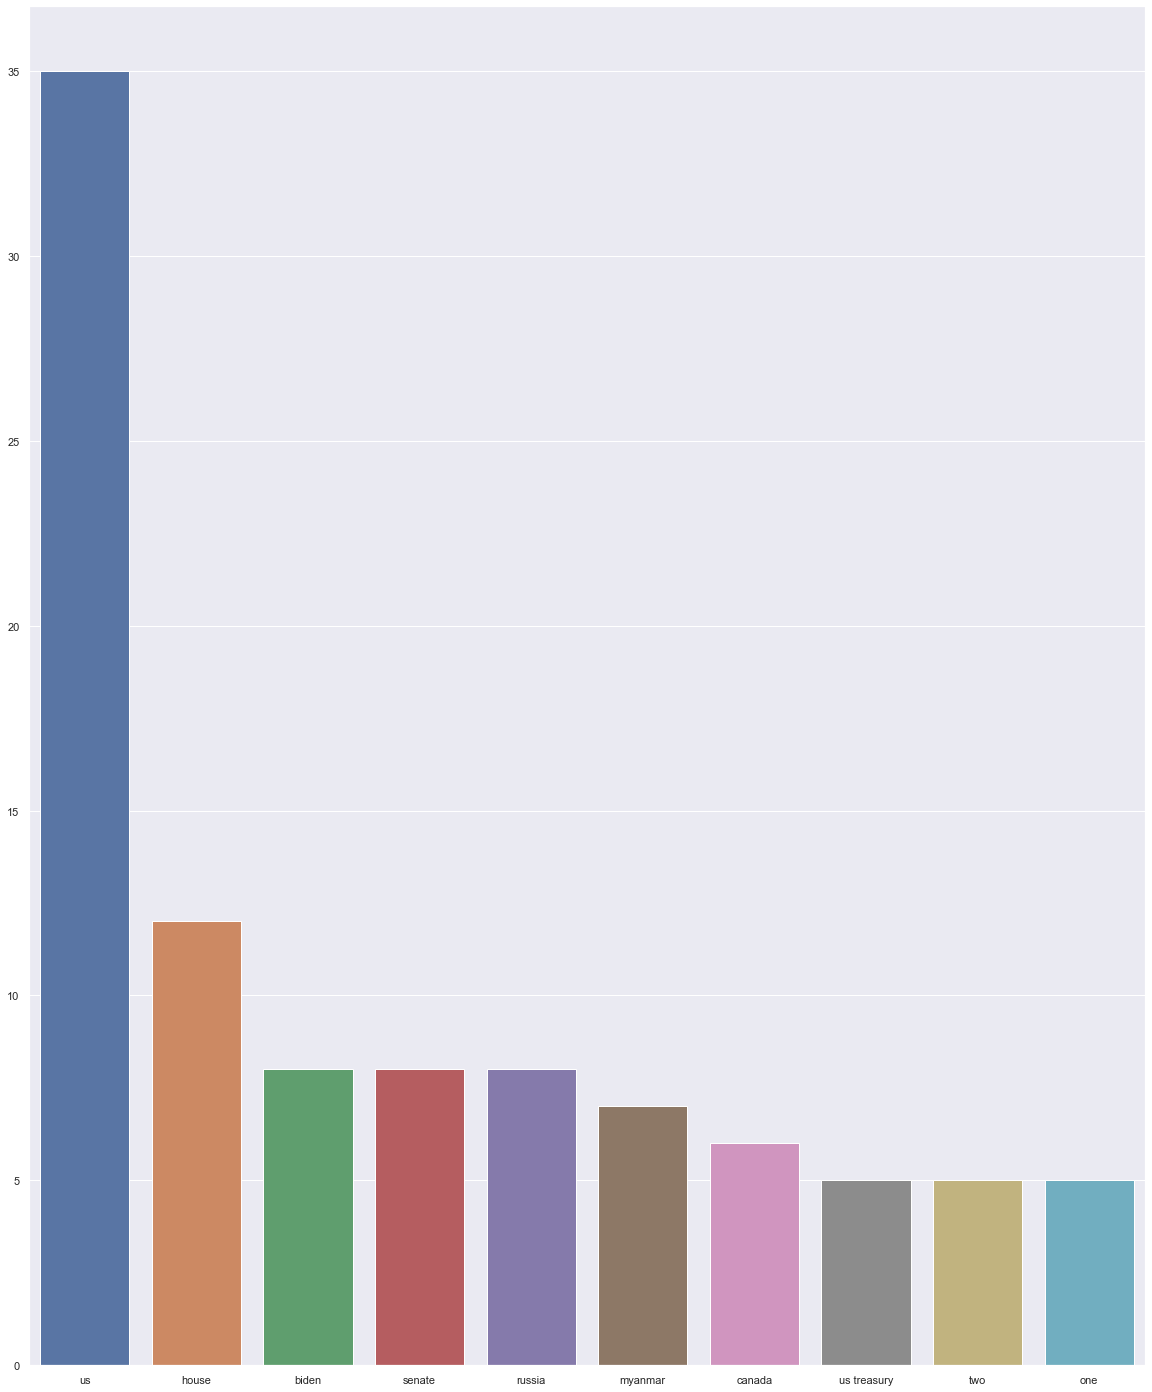

In [22]:
# Frequency plot of Named Entities - an interim topic list in itself

sns.set_style('dark')
sns.set_palette('pastel')
sns.set(rc={'figure.figsize':(20,25)})

sns.barplot(x=similarized_entities_list.value_counts()[:10].index, y=similarized_entities_list.value_counts()[:10])